# Part 1

In [1]:
!pip install pytorch-metric-learning

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import torch.nn.functional as F

In [3]:
# Load MNIST dataset (subset for faster training)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Use only a small subset to speed up training
train_subset = Subset(trainset, np.random.choice(len(trainset), 10000, replace=False))
test_subset = Subset(testset, np.random.choice(len(testset), 2000, replace=False))

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

# Define different models
class CNNModel(nn.Module):  # No hidden layer, Softmax output
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.conv_class = nn.Conv2d(64, 10, kernel_size=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = self.conv_class(x)
        x = F.adaptive_avg_pool2d(x, (1,1))
        x = x.view(x.size(0), -1)

        return torch.softmax(x, dim=1)

# 3. Initialize Model and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 4. Training Loop
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# 5. Testing Loop
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)')

# 6. Run Training and Testing
for epoch in range(1, 30):
    train(epoch)
    test()

# 7. Example Inference
def predict(image):
    model.eval()
    with torch.no_grad():
        image = image.to(device).unsqueeze(0)  # Add batch dimension
        output = model(image)
        probabilities = torch.softmax(output, dim=1)
    return probabilities.cpu().numpy().flatten()

Test set: Average loss: 0.0351, Accuracy: 589/2000 (29%)
Test set: Average loss: 0.0341, Accuracy: 720/2000 (36%)
Test set: Average loss: 0.0334, Accuracy: 827/2000 (41%)
Test set: Average loss: 0.0327, Accuracy: 886/2000 (44%)
Test set: Average loss: 0.0318, Accuracy: 1036/2000 (52%)
Test set: Average loss: 0.0312, Accuracy: 1122/2000 (56%)
Test set: Average loss: 0.0307, Accuracy: 1152/2000 (58%)
Test set: Average loss: 0.0304, Accuracy: 1216/2000 (61%)
Test set: Average loss: 0.0301, Accuracy: 1252/2000 (63%)
Test set: Average loss: 0.0294, Accuracy: 1343/2000 (67%)
Test set: Average loss: 0.0290, Accuracy: 1389/2000 (69%)
Test set: Average loss: 0.0288, Accuracy: 1402/2000 (70%)
Test set: Average loss: 0.0284, Accuracy: 1439/2000 (72%)
Test set: Average loss: 0.0285, Accuracy: 1410/2000 (70%)
Test set: Average loss: 0.0282, Accuracy: 1448/2000 (72%)
Test set: Average loss: 0.0282, Accuracy: 1447/2000 (72%)
Test set: Average loss: 0.0280, Accuracy: 1463/2000 (73%)
Test set: Average 

## We use confusion matrix to see the mistakes between the classes

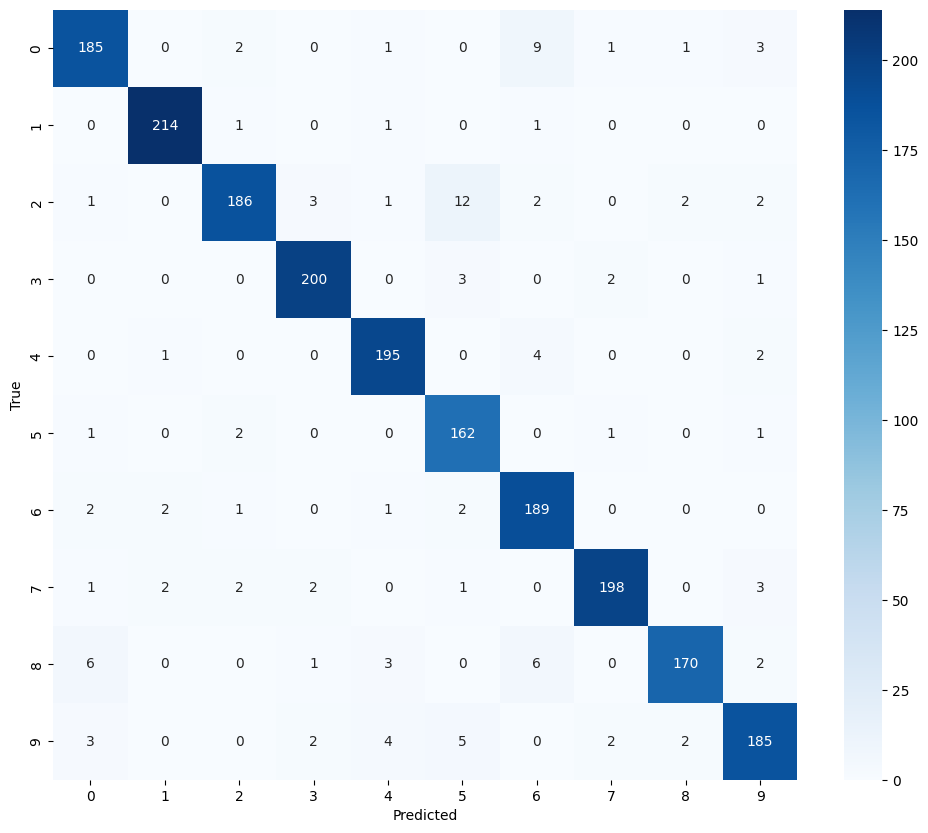

بیشترین اشتباه بین کلاس 2 و 5


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

max_error = 0
confused_classes = (0, 0)
for i in range(10):
    for j in range(10):
        if i != j and cm[i, j] > max_error:
            max_error = cm[i, j]
            confused_classes = (i, j)
print(f"most mistake between classes {confused_classes[0]} و {confused_classes[1]}")

# Part 2 
# Visualize the embedding of the two classes with UMAP

In [5]:
!pip install umap-learn

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


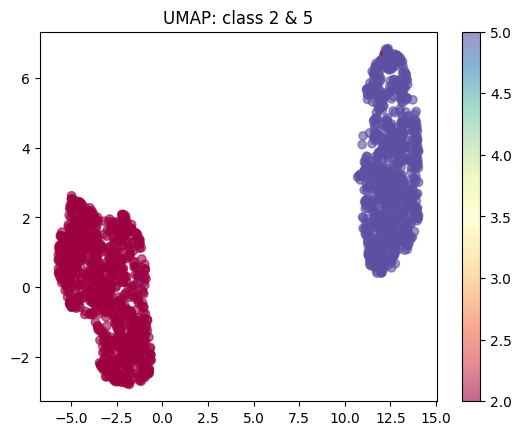

In [29]:
import umap

class EmbeddingExtractor(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.features = nn.Sequential(
            original_model.conv1,
            nn.ReLU(),
            original_model.pool,
            original_model.conv2,
            nn.ReLU(),
            original_model.pool
        )

    def forward(self, x):
        return self.features(x).view(x.size(0), -1)

embedding_model = EmbeddingExtractor(model).to(device)

class_a, class_b = confused_classes
mask = np.isin(test_subset.dataset.targets, [class_a, class_b])
subset_indices = np.where(mask)[0][:2000]
subset = Subset(test_subset.dataset, subset_indices)
subset_loader = DataLoader(subset, batch_size=64)

embeddings = []
labels = []
with torch.no_grad():
    for data, target in subset_loader:
        data = data.to(device)
        emb = embedding_model(data).cpu().numpy()
        embeddings.append(emb)
        labels.append(target.numpy())

embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)

reducer = umap.UMAP(n_components=2)
umap_result = reducer.fit_transform(embeddings)
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=labels, cmap='Spectral', alpha=0.6)
plt.colorbar()
plt.title(f'UMAP: class {class_a} & {class_b}')
plt.show()

# Part 3

## Triplet loss makes it so that the data points from different classes are more apart
## This difference is usually euclidean distance but it can be other distances like cosine distance
## Contrastive loss is almost identical to triplet loss, but the difference is that triplet loss alows a variance of distance within the same class but contrastive does notم
## Triplet loss formula is as follows:
## L=max(d(a, p) - d(a, n) + m, 0)

# Part 4

In [9]:
from pytorch_metric_learning import miners, losses


# Modified Triplet Model Definition
class TripletModel(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.features = nn.Sequential(
            original_model.conv1,
            nn.ReLU(),
            original_model.pool,
            original_model.conv2,
            nn.ReLU(),
            original_model.pool
        )
        self.conv_class = original_model.conv_class
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.embed_proj = nn.Linear(64*7*7, 128)  # Embedding projection

    def forward(self, x):
        x = self.features(x)

        # Embeddings (L2-normalized)
        embeddings = x.view(x.size(0), -1)
        embeddings = self.embed_proj(embeddings)
        embeddings = F.normalize(embeddings, p=2, dim=1)

        # Classification
        x = self.conv_class(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        return x, embeddings  # Return logits and embeddings

# Initialize model and components
model_triplet = TripletModel(model).to(device)
optimizer = optim.AdamW(model_triplet.parameters(), lr=0.001, weight_decay=1e-4)
miner = miners.MultiSimilarityMiner()
triplet_loss = losses.TripletMarginLoss(margin=0.2)

# Training and Testing Functions
def train(epoch):
    model_triplet.train()
    total_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        logits, embeddings = model_triplet(data)

        # Triplet mining and loss calculation
        indices_tuple = miner(embeddings, target)
        loss_ce = criterion(logits, target)
        loss_triplet = triplet_loss(embeddings, target, indices_tuple)
        loss = loss_ce + 0.1 * loss_triplet

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = logits.argmax(dim=1)
        correct += pred.eq(target).sum().item()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.4f}')

    avg_loss = total_loss / len(train_loader)
    acc = 100. * correct / len(train_loader.dataset)
    print(f'Train set: Average loss: {avg_loss:.4f}, Accuracy: {correct}/{len(train_loader.dataset)} ({acc:.0f}%)')

def test():
    model_triplet.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            logits, _ = model_triplet(data)
            test_loss += criterion(logits, target).item()
            pred = logits.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.0f}%)\n')

# Run training and testing
for epoch in range(1, 31):
    train(epoch)
    test()
    torch.save(model_triplet.state_dict(), f'triplet_model_epoch_{epoch}.pth')

Train Epoch: 1 [0/10000] Loss: 0.3053
Train Epoch: 1 [6400/10000] Loss: 0.3291
Train set: Average loss: 0.2650, Accuracy: 9271/10000 (93%)

Test set: Average loss: 0.0041, Accuracy: 1850/2000 (92%)

Train Epoch: 2 [0/10000] Loss: 0.2394
Train Epoch: 2 [6400/10000] Loss: 0.2471
Train set: Average loss: 0.2577, Accuracy: 9271/10000 (93%)

Test set: Average loss: 0.0042, Accuracy: 1846/2000 (92%)

Train Epoch: 3 [0/10000] Loss: 0.1835
Train Epoch: 3 [6400/10000] Loss: 0.1677
Train set: Average loss: 0.2467, Accuracy: 9316/10000 (93%)

Test set: Average loss: 0.0039, Accuracy: 1858/2000 (93%)

Train Epoch: 4 [0/10000] Loss: 0.1161
Train Epoch: 4 [6400/10000] Loss: 0.3921
Train set: Average loss: 0.2459, Accuracy: 9282/10000 (93%)

Test set: Average loss: 0.0039, Accuracy: 1861/2000 (93%)

Train Epoch: 5 [0/10000] Loss: 0.3173
Train Epoch: 5 [6400/10000] Loss: 0.1523
Train set: Average loss: 0.2342, Accuracy: 9371/10000 (94%)

Test set: Average loss: 0.0036, Accuracy: 1879/2000 (94%)

Train

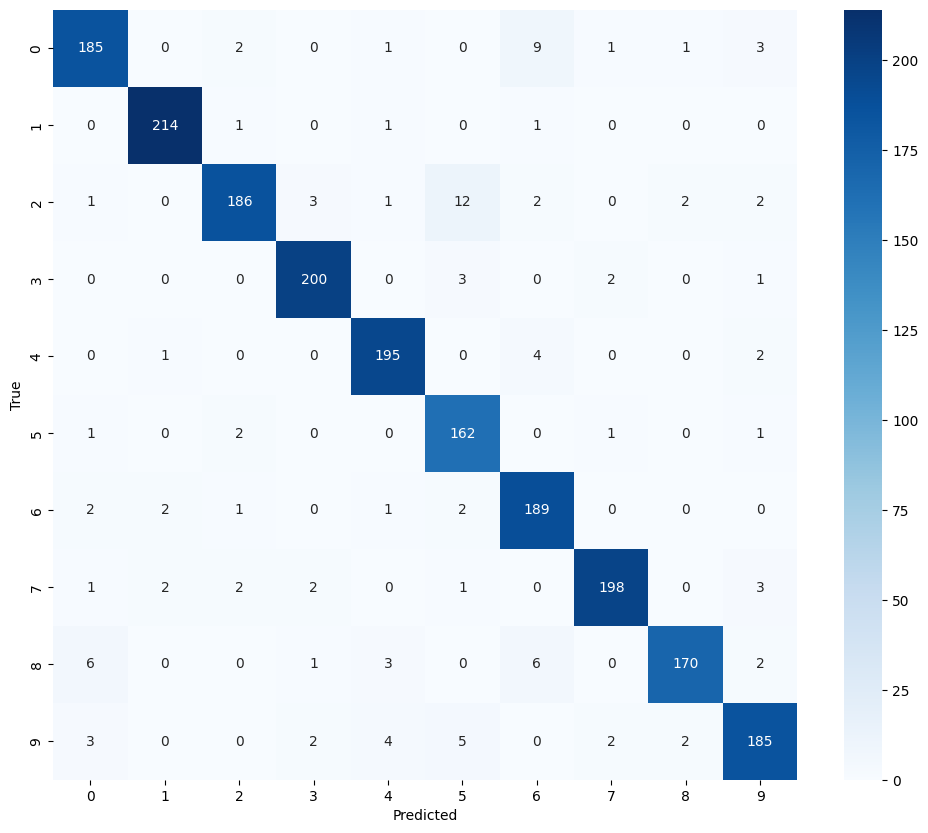

بیشترین اشتباه بین کلاس 2 و 5


In [ ]:
all_preds_t = []
all_labels_t = []
model_triplet.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model_triplet(data)[0]
        output_soft = torch.softmax(output, dim=1)
        pred = output_soft.argmax(dim=1)
        all_preds_t.extend(pred.cpu().numpy())
        all_labels_t.extend(target.cpu().numpy())



cm_t = confusion_matrix(all_labels_t, all_preds_t)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_t, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

max_error_t = 0
confused_classes_t = (0, 0)
for i in range(10):
    for j in range(10):
        if i != j and cm_t[i, j] > max_error_t:
            max_error_t = cm_t[i, j]
            confused_classes_t = (i, j)
print(f"Most mistakes between {confused_classes_t[0]} و {confused_classes_t[1]}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


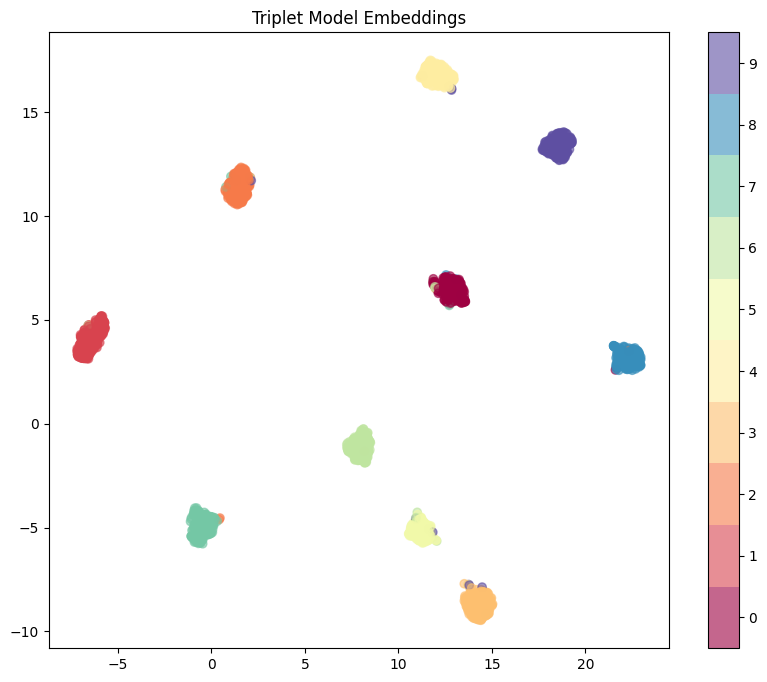

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


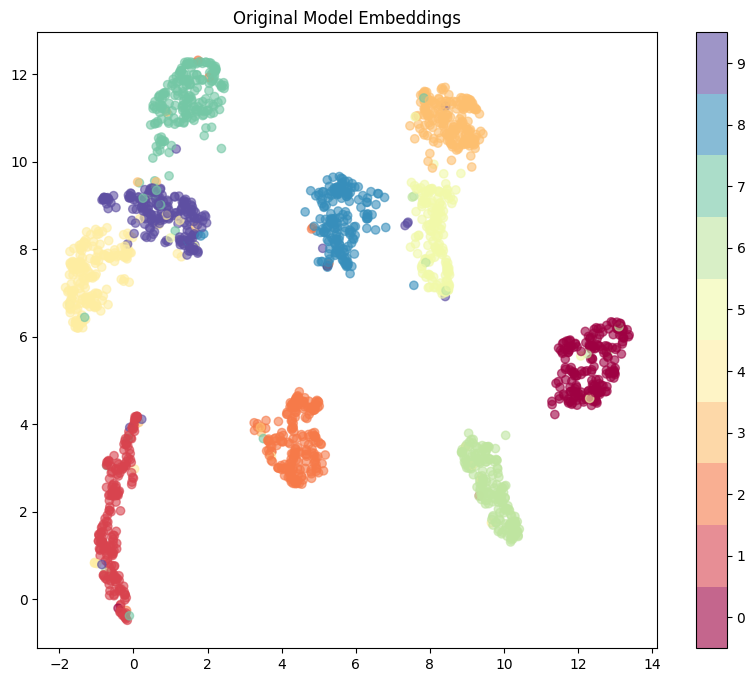

In [31]:
def visualize_umap(model, dataloader, title="Embedding Space"):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for data, target in dataloader:
            data = data.to(device)

            # Handle different model outputs
            outputs = model(data)

            # TripletModel returns (logits, embeddings)
            if isinstance(outputs, tuple):
                _, emb = outputs  # Unpack embeddings
            # Original model returns only embeddings
            else:
                emb = outputs

            embeddings.append(emb.cpu().numpy())
            labels.append(target.numpy())

    # Rest remains the same
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)

    reducer = umap.UMAP()
    projected = reducer.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    plt.scatter(projected[:, 0], projected[:, 1], c=labels, cmap='Spectral', alpha=0.6)
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
    plt.title(title)
    plt.show()

# For TripletModel
visualize_umap(model_triplet, test_loader, "Triplet Model Embeddings")

# For Original Model (modified)
class BaseEmbeddingModel(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.features = nn.Sequential(
            original_model.conv1,
            nn.ReLU(),
            original_model.pool,
            original_model.conv2,
            nn.ReLU(),
            original_model.pool
        )

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)  # Single output

visualize_umap(BaseEmbeddingModel(model), test_loader, "Original Model Embeddings")